In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16,MobileNet
from keras.applications.vgg16 import VGG16
from keras import Sequential
from keras.layers import Flatten , Dense
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
import random
import shutil

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


## 1. Import dataset to get train + validation sets:

In [ ]:
# Check if the file exists
if os.path.exists('data_exist.txt'):
    with open('data_exist.txt', 'r') as file:
        # Read and print the contents of the file
        file_contents = file.read().strip()
        if file_contents:  # Check if the file is not empty
            PATH = file_contents
            print(PATH)
        else:
            print("File is empty.")
else:
    dataset_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
    # Download and extract the dataset to the specified directory
    path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)
    PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

    # Write the PATH to the file
    with open('data_exist.txt', 'w') as file:
        file.write(PATH)

    print('Dataset downloaded and PATH written to data_exist.txt')



/root/.keras/datasets/cats_and_dogs_filtered


## 2. Adding test set :


In [ ]:
# check if test set directory doesnt exist yet :
PATH_to_testSet = os.path.join(PATH, 'test')
PATH_to_testSet_cat = os.path.join(PATH_to_testSet, 'cats')
PATH_to_testSet_dog = os.path.join(PATH_to_testSet, 'dogs')


# if we dont already have a test set
if os.path.isdir(PATH_to_testSet) is False:
    os.makedirs(PATH_to_testSet) # we create the path directory for test
    os.makedirs(PATH_to_testSet_cat) # we create the path directory test/cat
    os.makedirs(PATH_to_testSet_dog) # we create the path directory test/cat



### function to devide validation data to 50% test and 50% validation

In [ ]:
def move_half_random_elements(source_directory, destination_directory):
    # Check if the source directory exists
    if not os.path.exists(source_directory):
        return f"Source directory '{source_directory}' does not exist."

    if os.listdir(destination_directory):
        return f"destination directory '{destination_directory}' is not empty."

    # Check if the destination directory exists; if not, create it
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    # List all files and directories in the source directory
    elements = os.listdir(source_directory)

    # Randomly select half of the elements
    num_elements_to_move = len(elements) // 2
    elements_to_move = random.sample(elements, num_elements_to_move)

    # Move the selected elements to the destination directory
    for element in elements_to_move:
        source_path = os.path.join(source_directory, element)
        destination_path = os.path.join(destination_directory, element)
        shutil.move(source_path, destination_path)

    return f"Moved {num_elements_to_move} random elements from '{source_directory}' to '{destination_directory}'."


### calling the function :

In [ ]:

PATH_to_validation_cats= os.path.join(PATH, 'validation/cats')
PATH_to_validation_dogs= os.path.join(PATH, 'validation/dogs')

print(move_half_random_elements(PATH_to_validation_cats, PATH_to_testSet_cat))
print(move_half_random_elements(PATH_to_validation_dogs, PATH_to_testSet_dog))



destination directory '/root/.keras/datasets/cats_and_dogs_filtered/test/cats' is not empty.
destination directory '/root/.keras/datasets/cats_and_dogs_filtered/test/dogs' is not empty.


# 3. Image preprocessing:

In [ ]:
PATH_to_validation = os.path.dirname(PATH_to_validation_cats)
PATH_to_trainSet = os.path.join(PATH, 'train')
image_h = 224
image_w = 224
image_c = 3
image_shape=(image_h,image_w,image_c)

train_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    directory=PATH_to_trainSet,target_size=(image_h,image_w),classes=['cats','dogs'],batch_size=10)

validation_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    directory=PATH_to_validation,target_size=(image_h,image_w),classes=['cats','dogs'],batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    directory=PATH_to_testSet,target_size=(image_h,image_w),classes=['cats','dogs'],batch_size=10, shuffle=False)


Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


##  4. Visualize the Data

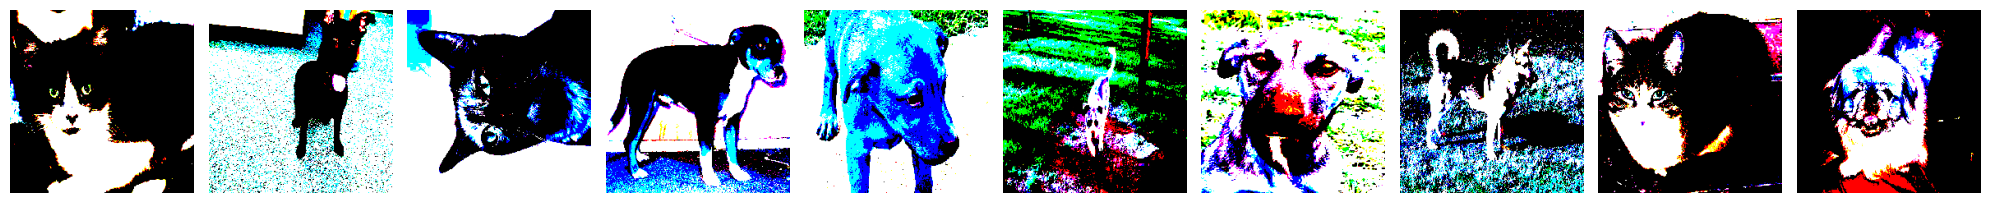

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
images , lable = next(train_batches)


def plotImg(img_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes=axes.flatten()
    for img ,ax in zip(img_arr, axes):
      ax.imshow(img)
      ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImg(images)
print(lable)

#### Visualisation test set :


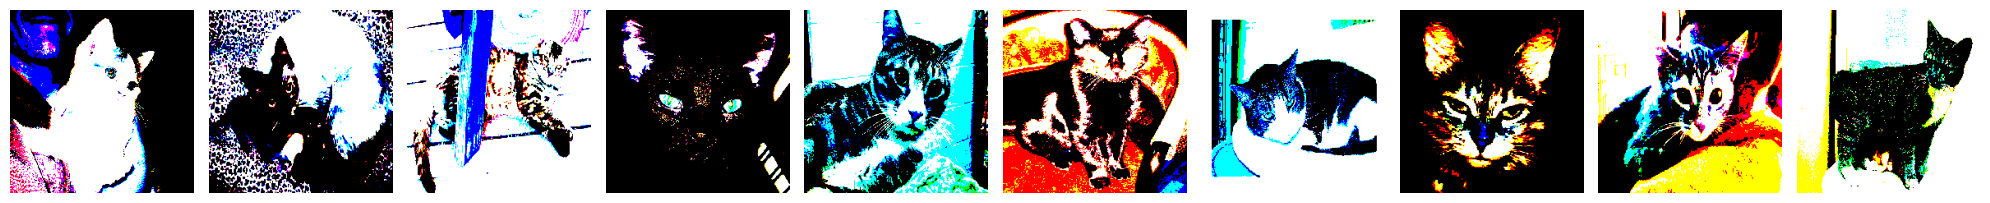

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
imagestest , labletest = next(test_batches)
plotImg(imagestest)
print(labletest)

## Using transfer learning:

### Build fine-tuned vgg16 model :

In [ ]:
# Load the pre-trained VGG16 model without the top (output) layer
base_model = VGG16( weights='imagenet')

# Define the input shape based on the last layer of the base model
input_shape = base_model.layers[-1].output_shape[1:]

# Create a Sequential model
model = Sequential()


for layer in base_model.layers[:-1]:
  model.add(layer)

# the layers from vgg16 model shoud not be trainble
for layer in model.layers:
    layer.trainable = False


model.add(Dense(units=2,activation='linear',name='outputLayer'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## Making Predictions:

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.01),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches,validation_data=validation_batches,epochs=2,verbose=2)

Epoch 1/2
200/200 - 1378s - loss: 0.2509 - accuracy: 0.9895 - val_loss: 0.9953 - val_accuracy: 0.9800 - 1378s/epoch - 7s/step
Epoch 2/2
200/200 - 1379s - loss: 0.2706 - accuracy: 0.9895 - val_loss: 0.9164 - val_accuracy: 0.9780 - 1379s/epoch - 7s/step


In [ ]:
y_test_pred= model.predict(x=test_batches,verbose=2)

50/50 - 265s - 265s/epoch - 5s/step


### Accuracy :

In [ ]:
y_test_pred = np.argmax(y_test_pred,axis=-1)
cm = confusion_matrix(y_true=test_batches.classes,y_pred=y_test_pred)

### Plot confusion matrix:

In [ ]:
# Plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (confusion matrx): Predicted labels.
        classes (list): List of class labels (strings) to label the matrix.
        normalize (bool, optional): If True, normalize the matrix. Default is False.
        title (str, optional): Title of the plot. Default is None.
        cmap (matplotlib colormap, optional): Color map to use for the plot. Default is plt.cm.Blues.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    if title is not None:
        plt.title(title)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]:.2f}", horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

In [ ]:
test_batches.class_indices
cm_plot_labels = ['cats','dogs']

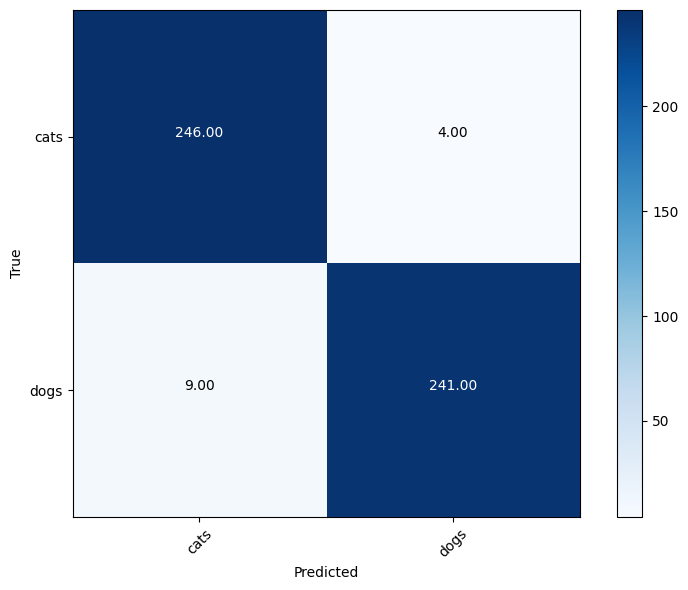

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels)